<ipython-input-1-e1aeb7739259>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64


<ipython-input-1-e1aeb7739259>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


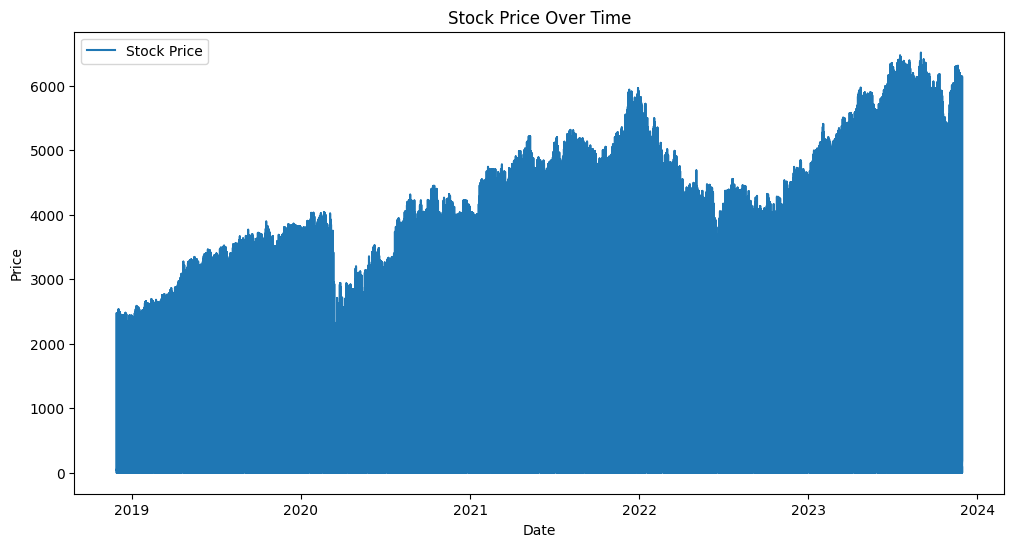

                                 Open        High         Low       Close  \
Date                                                                        
2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

                              Volume  Dividends  Stock Splits Company  
Date                                                                   
2018-11-29 00:00:00-05:00  167080000       0.00           0.0    AAPL  
2018-11-29 00:00:00-05:00   28123200       0.00           0.0    MSFT  
2018-11-29 00:00:00-05:00   31004000       0.00           0.0   GOOGL  
2018-11-29 00:00:00-05:00  132264000       0.00           0.0    AMZN  
2018-11-29 00:00:00-05:00   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (replace with your dataset path)
df = pd.read_csv('/content/drive/MyDrive/Massive Yahoo Finance Dataset/stock_details_5_years.csv')

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the Date as the index for easy time-series analysis
df.set_index('Date', inplace=True)

# Check for missing values in the dataset
print(df.isnull().sum())

# Handle missing values by forward filling (you can also choose to drop them)
df.fillna(method='ffill', inplace=True)

# Visualize the stock price (e.g., Close price)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Stock Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the first few rows of the dataset
print(df.head())


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


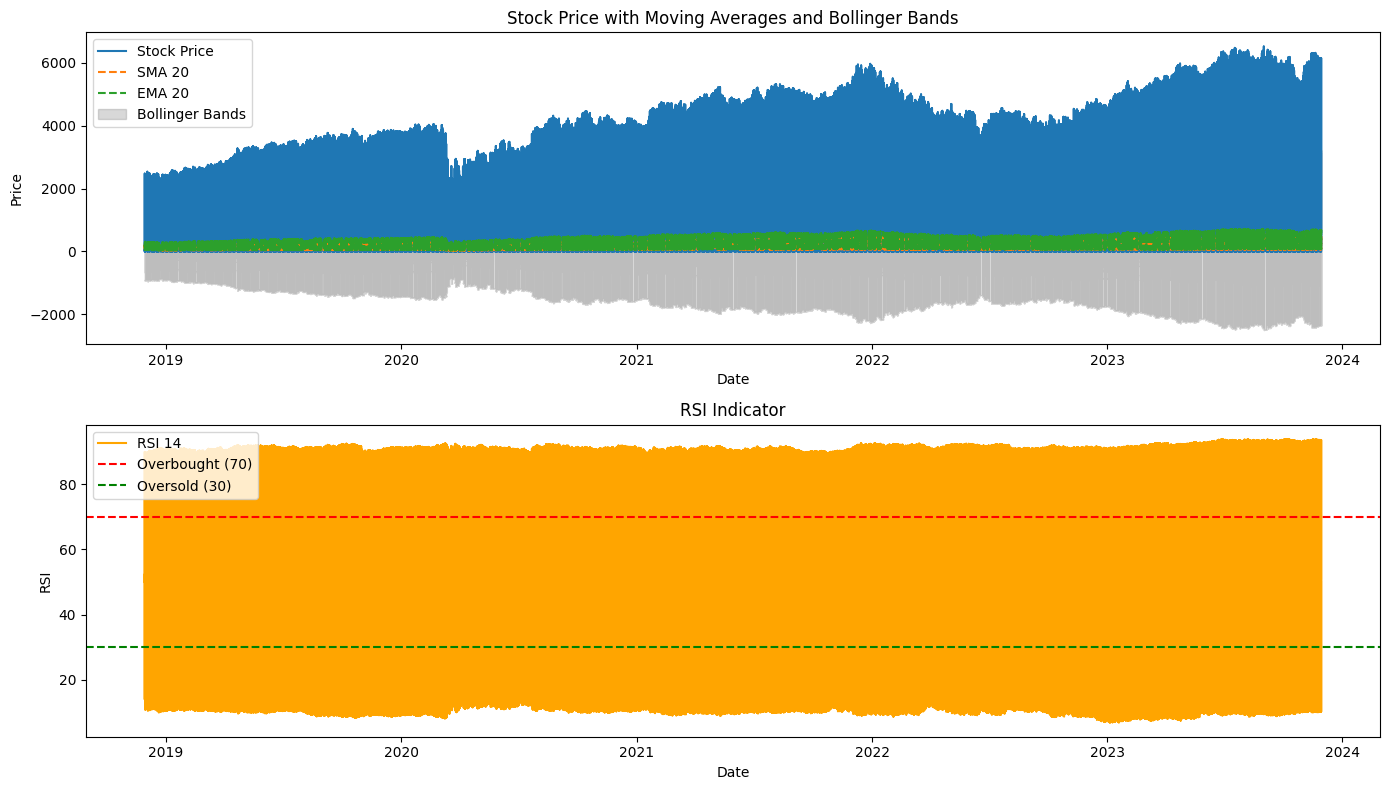

In [ ]:
import numpy as np

# 1. Simple Moving Average (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# 2. Exponential Moving Average (EMA)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# 3. Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

# 4. Bollinger Bands
window = 20
df['SMA_20'] = df['Close'].rolling(window=window).mean()
df['Bollinger_Upper'] = df['SMA_20'] + (df['Close'].rolling(window=window).std() * 2)
df['Bollinger_Lower'] = df['SMA_20'] - (df['Close'].rolling(window=window).std() * 2)

# Visualize the indicators
plt.figure(figsize=(14, 8))

# Plot stock price and indicators
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Stock Price')
plt.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df.index, df['EMA_20'], label='EMA 20', linestyle='--')
plt.fill_between(df.index, df['Bollinger_Upper'], df['Bollinger_Lower'], color='gray', alpha=0.3, label='Bollinger Bands')
plt.title('Stock Price with Moving Averages and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(df.index, df['RSI_14'], label='RSI 14', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

plt.tight_layout()
plt.show()


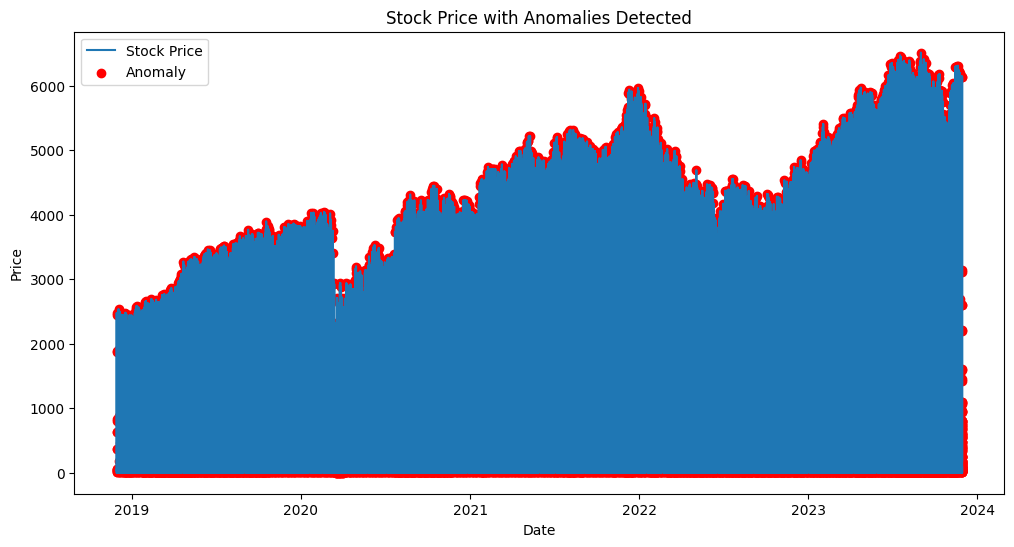

In [ ]:
from sklearn.ensemble import IsolationForest

# Prepare the data for anomaly detection (only use the numerical columns for training)
features = df[['Close', 'SMA_20', 'EMA_20', 'RSI_14']]  # Add more features as needed

# Initialize Isolation Forest
model = IsolationForest(contamination=0.05)  # Adjust contamination rate based on expected anomalies

# Fit the model
df['anomaly'] = model.fit_predict(features)

# Map -1 (anomaly) and 1 (normal) to boolean values for easier visualization
df['anomaly'] = df['anomaly'] == -1

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Stock Price')
plt.scatter(df.index[df['anomaly']], df['Close'][df['anomaly']], color='red', label='Anomaly')
plt.title('Stock Price with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer for stock price prediction

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict the stock price
predicted_price = model.predict(X_test)

# Inverse transform to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 732s 48ms/step - loss: 0.0015
Epoch 2/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 733s 48ms/step - loss: 0.0011
Epoch 3/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 731s 47ms/step - loss: 4.5027e-04
Epoch 4/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 742s 47ms/step - loss: 3.1573e-04
Epoch 5/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 739s 47ms/step - loss: 2.1618e-04
Epoch 6/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 756s 48ms/step - loss: 1.4792e-04
Epoch 7/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 739s 47ms/step - loss: 1.0900e-04
Epoch 8/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 716s 48ms/step - loss: 8.4218e-05
Epoch 9/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 728s 48ms/step - loss: 6.2507e-05
Epoch 10/10
15073/15073 ━━━━━━━━━━━━━━━━━━━━ 737s 48ms/step - loss: 5.2431e-05
3769/3769 ━━━━━━━━━━━━━━━━━━━━ 55s 14ms/step


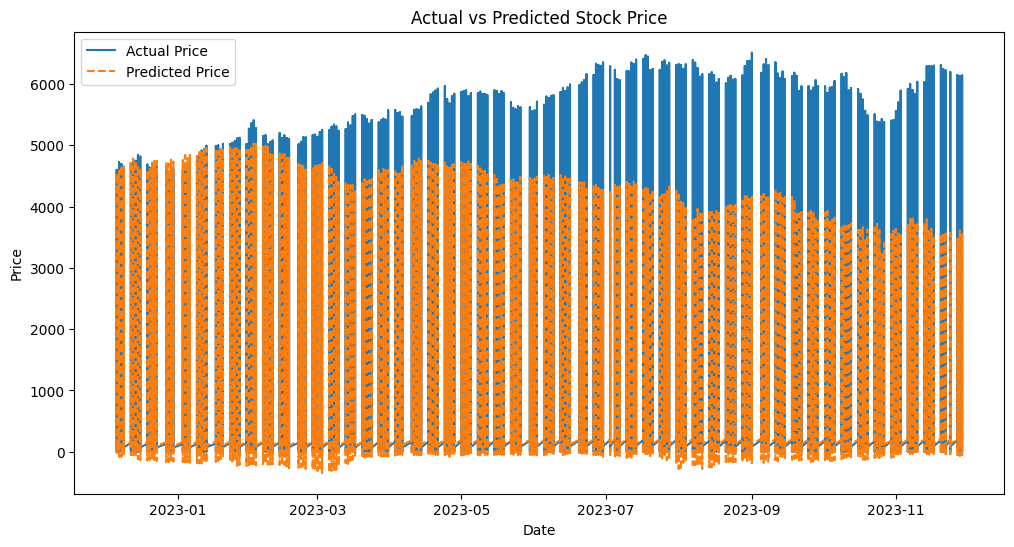

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price, label='Predicted Price', linestyle='--')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Save the model
model_path = 'lstm_stock_price_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to lstm_stock_price_model.h5
